In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# With GPU

In [28]:
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set the number of splits
k = 4

# Define the data directory and list the subdirectories
data_dir = "/content/drive/MyDrive/Data"
subdirs = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))]

# Create the list of class labels
class_labels = sorted([subdir.split('/')[-1] for subdir in subdirs])

# Count the number of images in each subdirectory
num_samples = sum([len(os.listdir(subdir)) for subdir in subdirs])

# Create indices for the samples
indices = np.arange(num_samples)

# Initialize a list to store the accuracies and confusion matrices
accuracies = []
confusion_matrices = []

# Set TensorFlow to use GPU growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Define the CNN model
def create_cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 360, 3), padding='valid'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (5, 5), activation='relu', padding='valid'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(16, (7, 7), activation='relu', padding='valid'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(len(class_labels), activation='softmax'))

    return model

# Perform K-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store accuracies for each iteration
accuracy_history = []

for fold, (train_index, test_index) in enumerate(kf.split(indices)):
    # Create the ImageDataGenerator for the training and test sets
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create the train, validation, and test generators
    train_generator = train_datagen.flow_from_directory(data_dir,
                                                       target_size=(240, 360),
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       subset='training',
                                                       seed=42,
                                                       classes=class_labels)
    
    validation_generator = train_datagen.flow_from_directory(data_dir,
                                                            target_size=(240, 360),
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            subset='validation',
                                                            seed=42,
                                                            classes=class_labels)

    test_generator = test_datagen.flow_from_directory(data_dir,
                                                     target_size=(240, 360),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     seed=42,
                                                     shuffle=False,
                                                     classes=class_labels)

    # Create the model
    model = create_cnn_model()

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model and store accuracy history
    history = model.fit(train_generator, validation_data=validation_generator, epochs=10)
    accuracy_history.append(history.history['accuracy'])

    # Evaluate the model
    _, test_acc = model.evaluate(test_generator)
    accuracies.append(test_acc)

    # Predict the classes for the test set
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)

    # Compute the confusion matrix
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

    # Save the model
    model.save(f'model_fold{fold}.h5')

    print(f"Validation accuracy for fold {fold}: {test_acc:.4f}")




1 Physical GPUs, 1 Logical GPUs
Found 10535 images belonging to 6 classes.
Found 2630 images belonging to 6 classes.
Found 13165 images belonging to 6 classes.
Epoch 1/10
330/330 [==============================] - 3589s 11s/step - loss: 0.9303 - accuracy: 0.6477 - val_loss: 1.6177 - val_accuracy: 0.3046
Epoch 2/10
330/330 [==============================] - 123s 372ms/step - loss: 0.4521 - accuracy: 0.8302 - val_loss: 1.4661 - val_accuracy: 0.4319
Epoch 3/10
330/330 [==============================] - 126s 381ms/step - loss: 0.2972 - accuracy: 0.9031 - val_loss: 1.8640 - val_accuracy: 0.3525
Epoch 4/10
330/330 [==============================] - 125s 379ms/step - loss: 0.2169 - accuracy: 0.9295 - val_loss: 1.8810 - val_accuracy: 0.4654
Epoch 5/10
330/330 [==============================] - 147s 444ms/step - loss: 0.1621 - accuracy: 0.9494 - val_loss: 2.1249 - val_accuracy: 0.4414
Epoch 6/10
330/330 [==============================] - 128s 387ms/step - loss: 0.1404 - accuracy: 0.9583 - val_l

# PLot

Average accuracy: 0.8785
Average Confusion Matrix:
[[1.86975e+03 1.40250e+02 3.50000e+00 2.65000e+01 3.30000e+01 0.00000e+00]
 [2.26250e+02 3.65525e+03 5.30000e+01 7.75000e+00 3.21000e+02 1.57500e+01]
 [1.10000e+01 7.50000e+00 9.84750e+02 1.47500e+01 1.20000e+01 0.00000e+00]
 [2.25000e+00 2.50000e-01 9.75000e+00 1.15650e+03 2.50000e-01 0.00000e+00]
 [4.95000e+01 4.93000e+02 5.00000e+00 3.25000e+00 3.04175e+03 4.50000e+00]
 [0.00000e+00 1.59000e+02 0.00000e+00 0.00000e+00 0.00000e+00 8.58000e+02]]


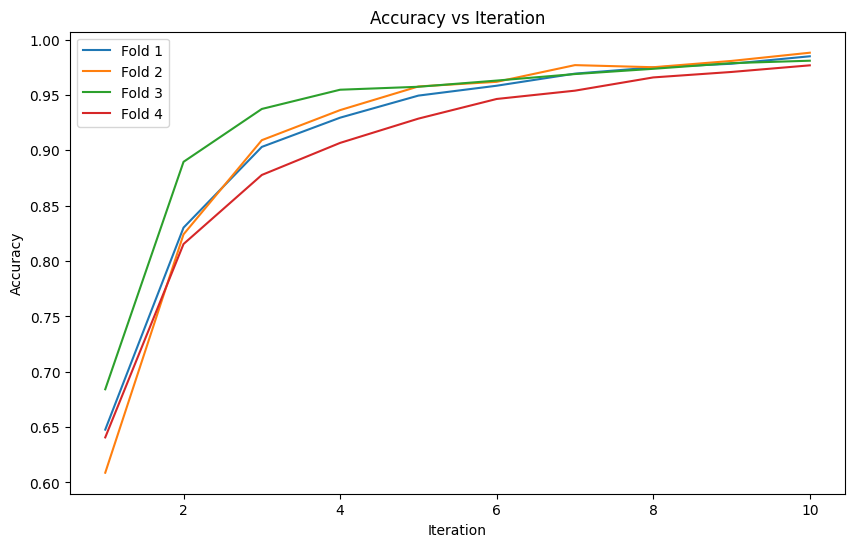

In [30]:
# Calculate and print the average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average accuracy: {average_accuracy:.4f}")

# Calculate and print the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)
print("Average Confusion Matrix:")
print(average_confusion_matrix)

# Plot accuracy vs iteration curve
plt.figure(figsize=(10, 6))
for i, accuracy in enumerate(accuracy_history):
    plt.plot(range(1, len(accuracy)+1), accuracy, label=f'Fold {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iteration')
plt.legend()
plt.show()

# Inference on a test image



In [31]:
# Load the saved model
saved_model = tf.keras.models.load_model(f"/content/model_fold4.h5")  # Load the model of the first fold

# Infrence

1/1 [==============================] - 0s 63ms/step


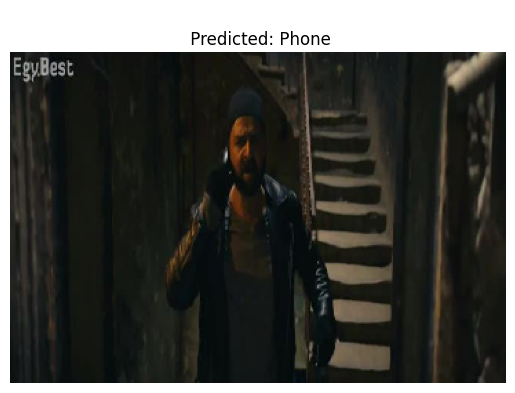

In [74]:
import random

# Get a random image from the test set
random_test_index = random.randint(0, len(test_generator) - 1)
test_image, _ = test_generator[random_test_index]

# Predict the label for the random test image
classes = ['Dancing', 'Driving', 'Explosion', 'Football', 'Phone', 'Shooting']
# Set the model to use for prediction
prediction_model = model if model is not None else saved_model

# Predict the label for the random test image
predicted_labels = prediction_model.predict(test_image)
predicted_labels = np.argmax(predicted_labels, axis=1)
predicted_class_labels = [class_labels[label] for label in predicted_labels]


# Display the random test image along with the predicted and actual class labels
plt.imshow(test_image[0])
plt.title(f" \n Predicted: {max(predicted_class_labels)}")
plt.axis('off')
plt.show()
